# Import Data

In [1]:
# Get Dataset
#Kaggle: https://www.kaggle.com/datasets/shivamb/go-emotions-google-emotions-dataset

!wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv
!wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_2.csv
!wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_3.csv

--2023-03-19 17:46:34--  https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 2a00:1450:4003:802::2010, 2a00:1450:4003:80a::2010, 2a00:1450:4003:80d::2010, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2a00:1450:4003:802::2010|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14174600 (14M) [application/octet-stream]
Saving to: ‘data/full_dataset/goemotions_1.csv’

goemotions_1.csv    100%[===================>]  13,52M  10,1MB/s    in 1,3s    

2023-03-19 17:46:37 (10,1 MB/s) - ‘data/full_dataset/goemotions_1.csv’ saved [14174600/14174600]

--2023-03-19 17:46:37--  https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_2.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 2a00:1450:4003:80a::2010, 2a00:1450:4003:80d::2010, 2a00:1450:4003:802::2010, ...
Connecting to storage.googleapis.com (storage.googleapis.co

In [36]:
#!pip install -q preprocessor
#!pip install -q contractions

In [24]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import preprocessor
import contractions
import re
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
tqdm.pandas()

In [2]:
DATA_PATH = 'data/full_dataset/goemotions_'

df1 = pd.read_csv(f'{DATA_PATH}1.csv')
df2 = pd.read_csv(f'{DATA_PATH}2.csv')
df3 = pd.read_csv(f'{DATA_PATH}3.csv')

frames = [df1,df2,df3]

df = pd.concat(frames)

df.head()

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,eew5j0j,Brdd9,nrl,t3_ajis4z,t1_eew18eq,1.548381e+09,1,False,0,...,0,0,0,0,0,0,0,1,0,0
1,>sexuality shouldn’t be a grouping category I...,eemcysk,TheGreen888,unpopularopinion,t3_ai4q37,t3_ai4q37,1.548084e+09,37,True,0,...,0,0,0,0,0,0,0,0,0,0
2,"You do right, if you don't care then fuck 'em!",ed2mah1,Labalool,confessions,t3_abru74,t1_ed2m7g7,1.546428e+09,37,False,0,...,0,0,0,0,0,0,0,0,0,1
3,Man I love reddit.,eeibobj,MrsRobertshaw,facepalm,t3_ahulml,t3_ahulml,1.547965e+09,18,False,0,...,1,0,0,0,0,0,0,0,0,0
4,"[NAME] was nowhere near them, he was by the Fa...",eda6yn6,American_Fascist713,starwarsspeculation,t3_ackt2f,t1_eda65q2,1.546669e+09,2,False,0,...,0,0,0,0,0,0,0,0,0,1


# Removing Useless Columns

In [3]:
df.columns

Index(['text', 'id', 'author', 'subreddit', 'link_id', 'parent_id',
       'created_utc', 'rater_id', 'example_very_unclear', 'admiration',
       'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion',
       'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust',
       'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy',
       'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief',
       'remorse', 'sadness', 'surprise', 'neutral'],
      dtype='object')

In [4]:
df = df.drop(columns=['author','subreddit','link_id','parent_id','created_utc','rater_id'])

In [5]:
df.head()

,text,id,example_very_unclear,admiration,amusement,anger,annoyance,approval,caring,confusion,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,eew5j0j,False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,>sexuality shouldn’t be a grouping category I...,eemcysk,True,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"You do right, if you don't care then fuck 'em!",ed2mah1,False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,Man I love reddit.,eeibobj,False,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,"[NAME] was nowhere near them, he was by the Fa...",eda6yn6,False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


# Data Visualization

In [6]:
#View emotions easier
emotions = set(df.columns[3:])
emotions

{'admiration',
 'amusement',
 'anger',
 'annoyance',
 'approval',
 'caring',
 'confusion',
 'curiosity',
 'desire',
 'disappointment',
 'disapproval',
 'disgust',
 'embarrassment',
 'excitement',
 'fear',
 'gratitude',
 'grief',
 'joy',
 'love',
 'nervousness',
 'neutral',
 'optimism',
 'pride',
 'realization',
 'relief',
 'remorse',
 'sadness',
 'surprise'}

Text(0.5, 1.0, 'Emotions by number of appearances')

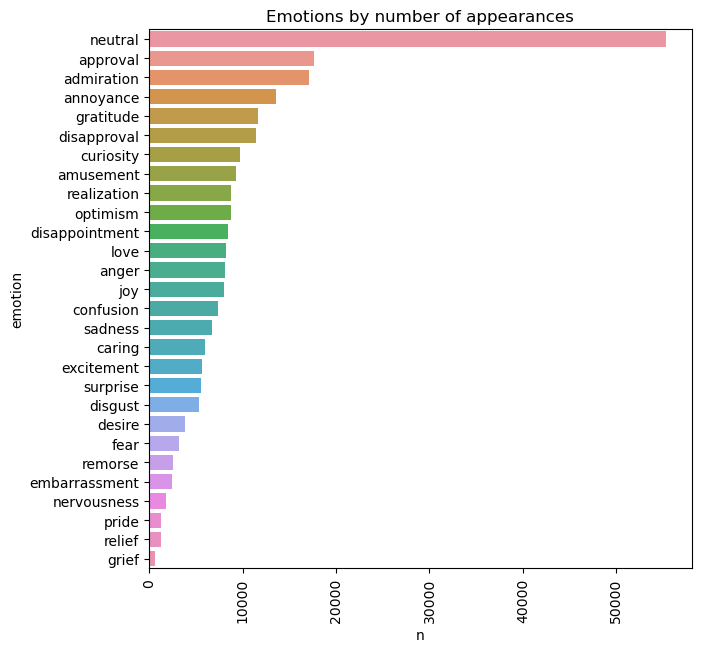

In [7]:
# Emotions Visualization by number of cases

temp = df[list(emotions)].sum(axis=0) \
    .reset_index() \
    .rename(columns={'index': 'emotion', 0: 'n'}) \
    .sort_values('n', ascending=False)

fig, ax = plt.subplots(figsize=(7, 7))
ax.tick_params(axis='x', rotation=90)
sns.barplot(data=temp, x='n', 
            y='emotion',
            dodge=False,
            ax=ax).set_title('Emotions by number of appearances')

In [8]:
# Concatenating emotions

pos = {'admiration','amusement','approval','caring','desire','excitement','gratitude','joy','love',
       'optimism','pride','relief'}
neg = {'sadness','fear','embarrassment','disapproval','disappointment','annoyance','anger','nervousness',
       'remorse','grief','disgust'}
amb= {'realization','surprise','curiosity','confusion','neutral'}

In [9]:
# Emotions and data vis

print("Length of data: ", len(df))
print("Number of emotions: ", len(emotions))
print("Number of positive emotions: ", len(pos))
print("Number of negative emotions: ", len(neg))
print("Number of ambiguous emotions: ", len(amb))

Length of data:  211225
Number of emotions:  28
Number of positive emotions:  12
Number of negative emotions:  11
Number of ambiguous emotions:  5


In [10]:
# Emotions dataframe to later on aggregate

df_emotion = pd.DataFrame()
df_emotion['emotion'] = list(emotions)
df_emotion['group'] = ''
df_emotion['group'].loc[df_emotion['emotion'].isin(pos)] = 'positive'
df_emotion['group'].loc[df_emotion['emotion'].isin(neg)] = 'negative'
df_emotion['group'].loc[df_emotion['emotion'].isin(amb)] = 'ambiguous'

In [11]:
df_emotion.head()

,emotion,group
0,disapproval,negative
1,grief,negative
2,caring,positive
3,remorse,negative
4,approval,positive


<Axes: xlabel='emotion', ylabel='true positive rate'>

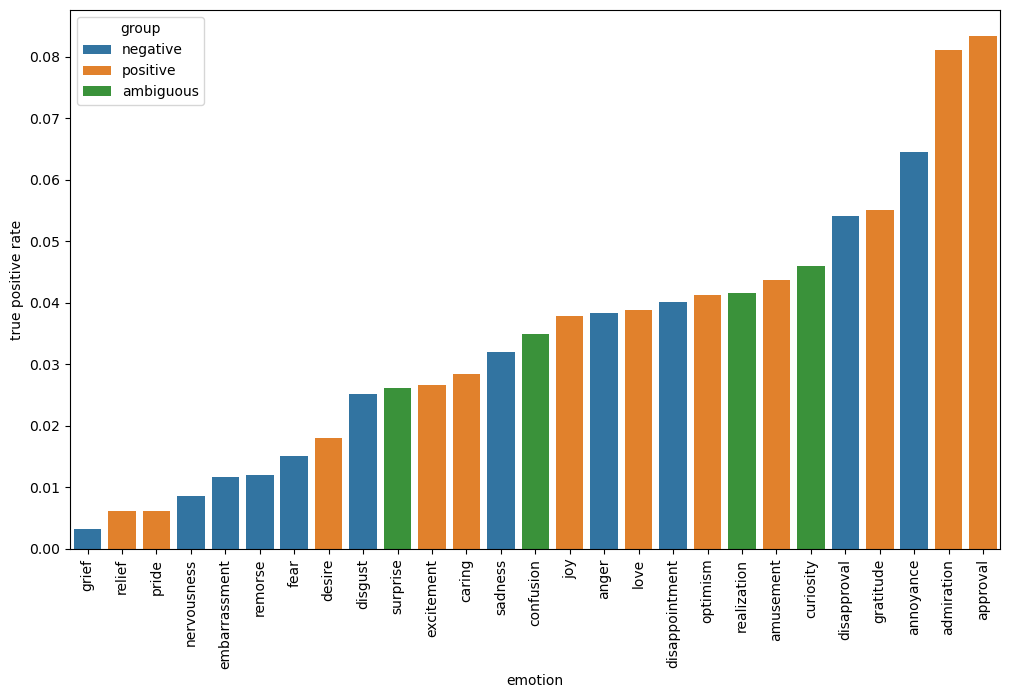

In [12]:
# Emotions by number of appearences but by group

temp = pd.DataFrame()
temp['true positive rate'] = df.iloc[:, 3:-1].mean(0)
temp['emotion'] = df.columns[3:-1]
temp = temp.merge(df_emotion, how='left', on='emotion')
temp = temp.sort_values('true positive rate')

fig, ax = plt.subplots(figsize=(12, 7))
ax.tick_params(axis='x', rotation=90)

sns.barplot(x=temp['emotion'], 
            y=temp['true positive rate'], 
            hue=temp['group'], 
            dodge=False)

# Cleaning DataSet

In [13]:
# FROM: https://www.kaggle.com/code/esknight/emotion-classification-final
# Function for cleaning text
def clean_text(text):
    re_number = re.compile('[0-9]+')
    re_url = re.compile("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+")
    re_tag = re.compile('\[[A-Z]+\]')
    re_char = re.compile('[^0-9a-zA-Z\s?!.,:\'\"//]+')
    re_char_clean = re.compile('[^0-9a-zA-Z\s?!.,\[\]]')
    re_punc = re.compile('[?!,.\'\"]')
  
    text = re.sub(re_char, "", text) # Remove unknown character 
    text = contractions.fix(text) # Expand contraction
    text = re.sub(re_url, ' [url] ', text) # Replace URL with number
    text = re.sub(re_char_clean, "", text) # Only alphanumeric and punctuations.
    #text = re.sub(re_punc, "", text) # Remove punctuation.
    text = text.lower() # Lower text
    text = " ".join([w for w in text.split(' ') if w != " "]) # Remove whitespace

    return text

In [14]:
df = df.drop(columns=['id','example_very_unclear'])

In [15]:
df.head()

,text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,>sexuality shouldn’t be a grouping category I...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"You do right, if you don't care then fuck 'em!",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,Man I love reddit.,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,"[NAME] was nowhere near them, he was by the Fa...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [16]:
# Clean text
df['clean_text'] = df['text'].progress_apply(clean_text)

  0%|          | 0/211225 [00:00<?, ?it/s]

In [17]:
df[['text','clean_text']].sample(5)

,text,clean_text
38615,Her little baby frown is adorable,her little baby frown is adorable
36248,Old toothless finally coming out of his den?,old toothless finally coming out of his den?
52919,Thank you! 💓❤,thank you!
63627,Super fake news. This wasn't brought up when d...,super fake news. this was not brought up when ...
42900,>I'm just trying to be respectful of the nativ...,i am just trying to be respectful of the nativ...


In [18]:
df['emotion'] = (df.iloc[:,1:] == 1).idxmax(1)

In [19]:
df.head()

,text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,optimism,pride,realization,relief,remorse,sadness,surprise,neutral,clean_text,emotion
0,That game hurt.,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,that game hurt.,sadness
1,>sexuality shouldn’t be a grouping category I...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,sexuality should not be a grouping category i...,admiration
2,"You do right, if you don't care then fuck 'em!",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,"you do right, if you do not care then fuck them!",neutral
3,Man I love reddit.,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,man i love reddit.,love
4,"[NAME] was nowhere near them, he was by the Fa...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,"name was nowhere near them, he was by the falc...",neutral


In [20]:
# Organizing df

df = df[['clean_text','emotion'] + [col for col in df.columns if col not in ['text', 'emotion','clean_text']]]

In [21]:
df.head()

,clean_text,emotion,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,that game hurt.,sadness,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,sexuality should not be a grouping category i...,admiration,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"you do right, if you do not care then fuck them!",neutral,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,man i love reddit.,love,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,"name was nowhere near them, he was by the falc...",neutral,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [22]:
# Removing empty texts

print(df.shape)

df = df[df['clean_text'] != '']

print(df.shape)

(211225, 30)
(211211, 30)


# Train / Test

In [37]:
OUTPUT_DIR = 'training_data'
TRAIN_OUTPUT = 'training_data/train_dataset.csv'
TEST_OUTPUT = 'training_data/test_dataset.csv'

In [46]:
def create_train_test(dataframe):
    if not os.path.exists(OUTPUT_DIR):
        os.mkdir(OUTPUT_DIR)
    train, test = train_test_split(dataframe, test_size=0.2, shuffle=True, random_state=0)
    train.to_csv(TRAIN_OUTPUT, index=None)
    test.to_csv(TEST_OUTPUT, index=None)

def load_train_test():
    df_train = pd.read_csv(TRAIN_OUTPUT)
    df_test = pd.read_csv(TEST_OUTPUT)
    
    print(f"Train Size: {df_train.shape[0]}, number of columns: {df_train.shape[1]}")
    print(f"Test Size: {df_test.shape[0]}, number of columns: {df_test.shape[1]}")
    print(f"Total Size: {df_train.shape[0] + df_test.shape[0]}")
    
    print("Train first rows:")
    print(df_train.head())
    return df_train, df_test, df_train.shape[0], df_test.shape[0], df_train.shape[0] + df_test.shape[0]

In [39]:
# In case is not loaded
create_train_test(df)

In [48]:
df_train, df_test, train_size, test_size, total_size = load_train_test()

Train Size: 168968, number of columns: 30
Test Size: 42243, number of columns: 30
Total Size: 211211
Train first rows:
                                          clean_text      emotion  admiration  \
0              dj finding consistency makes me happy          joy           0   
1                                  that is wonderful   admiration           1   
2  the more i know someone, the less i want to kn...      neutral           0   
3  what scares me is that now that this happened,...  disapproval           0   
4  was expecting a horrifically broken ankle. you...  realization           0   

   amusement  anger  annoyance  approval  caring  confusion  curiosity  ...  \
0          0      0          0         0       0          0          0  ...   
1          0      0          0         0       0          0          0  ...   
2          0      0          0         0       0          0          0  ...   
3          0      0          0         0       0          0          0  ...   

In [74]:
def represent_train_test_balance(train_df,test_df):
    # Class representation for train/test DS
    train_GO = (train_df.loc[:,list(emotions)].sum(axis=0) / train_size) * 100
    test_GO = (test_df.loc[:,list(emotions)].sum(axis=0) / test_size) * 100
    
    # Unique dataset for visualization purposes
    
    ds_GO = pd.DataFrame(data=[train_GO, test_GO]).T.reset_index(drop=False)
    ds_GO.columns = ['Emotion', 'Train','Test']
    ds_GO = ds_GO.sort_values('Train',ascending=False)
    ds_GO = ds_GO.melt(id_vars='Emotion', var_name='Dataset', value_vars=['Train','Test'],
                      value_name='Percentage')
    
    # Display dataset
    
    display(ds_GO.head(10))
    
    print("Graph Visualization")
    
    plt.figure(figsize=(20,15))
    sns.barplot(x='Percentage', y='Emotion', data=ds_GO, orient='h', hue='Dataset')
    plt.title('Percentage of samples per emotion in train and test datasets', fontweight='bold', fontsize=20)
    plt.xlabel('Percentage of all samples', fontweight='bold', fontsize=16)
    plt.ylabel('Emotions', fontweight='bold', fontsize= 16)
    plt.show()

,Emotion,Dataset,Percentage
0,neutral,Train,26.035107
1,approval,Train,8.335898
2,admiration,Train,8.124615
3,annoyance,Train,6.452701
4,gratitude,Train,5.518205
5,disapproval,Train,5.444226
6,curiosity,Train,4.599096
7,amusement,Train,4.426282
8,realization,Train,4.165286
9,optimism,Train,4.084205


Graph Visualization


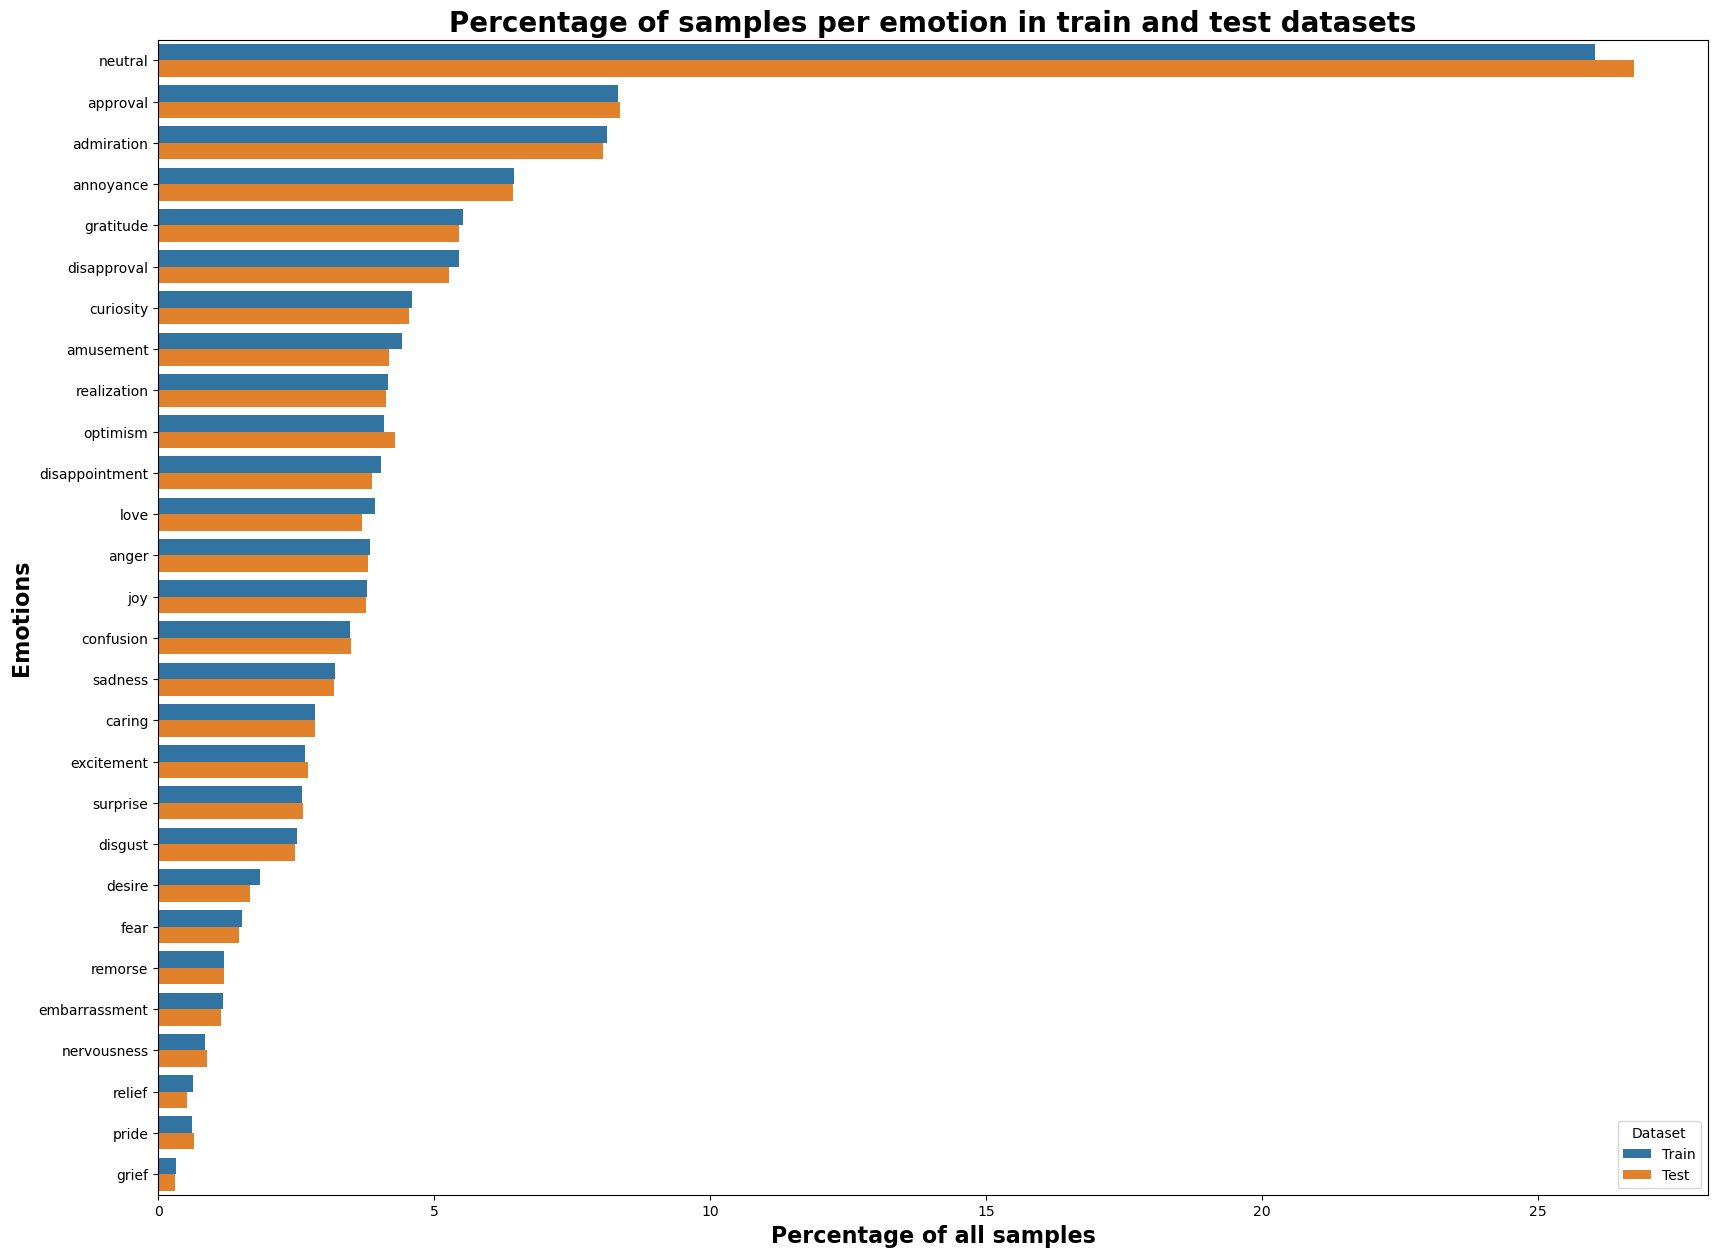

In [75]:
represent_train_test_balance(df_train, df_test)

# Pre-Trained Model - DistilBERT

In [129]:
# Imports

from transformers import DistilBertTokenizer, DistilBertModel, TrainingArguments, Trainer
, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from transformers.data.processors.utils import InputFeatures
import random
import torch
import platform
import sys
import sklearn as sk

In [131]:
model_path_or_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_path_or_name)
model = DistilBertModel.from_pretrained(model_path_or_name)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [91]:
def verify_sentence_length(df,column):
    print("DataFrame Sentence Lengths : ")
    list_length = [len(tokenizer.tokenize(sentence)) for sentence in df[column]]
    plt.hist(list_length)
    plt.show()
    print('Max Length Sentence in dataset: ', max(list_length))

DataFrame Sentence Lengths : 


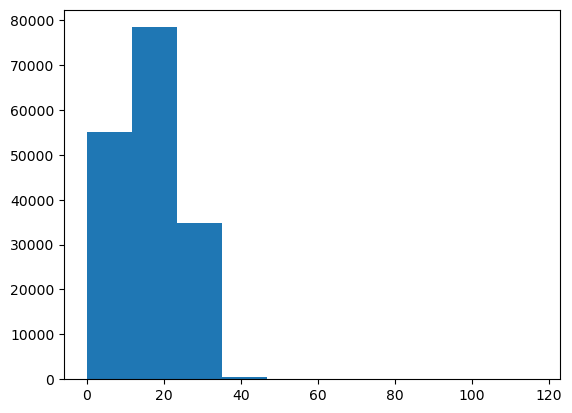

Max Length Sentence in dataset:  117
DataFrame Sentence Lengths : 


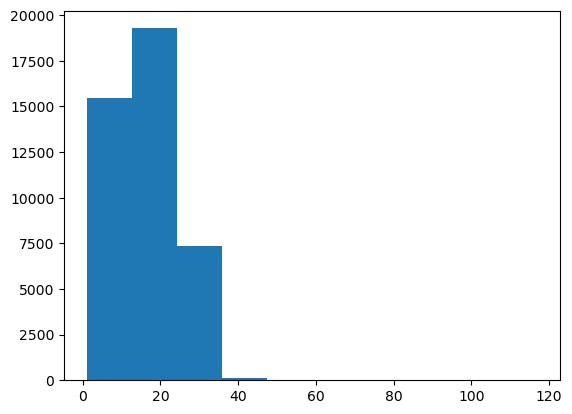

Max Length Sentence in dataset:  117


In [92]:
verify_sentence_length(df_train,'clean_text')
verify_sentence_length(df_test,'clean_text')

In [93]:
MAX_LEN = 256

In [99]:
print("Truncated training sequences: ", sum([len(tokenizer.tokenize(sentence)) > MAX_LEN for 
                                             sentence in df_train["clean_text"].to_list()]))

print("Truncated testing sequences: ", sum([len(tokenizer.tokenize(sentence)) > MAX_LEN for 
                                            sentence in df_test["clean_text"].to_list()]))

Truncated training sequences:  0
Truncated testing sequences:  0


In [97]:
# source https://github.com/hazemhosny/Emotion-Sentiment-Analysis
class ClassificationDataset(Dataset):
    def __init__(self, text, target, model_path_or_name, max_len, label_map):
        super(ClassificationDataset).__init__()
        """
        Args:
        text (List[str]): List of the training text
        target (List[str]): List of the training labels
        tokenizer_name (str): The tokenizer name (same as model_name).
        max_len (int): Maximum sentence length
        label_map (Dict[str,int]): A dictionary that maps the class labels to integer
        """
        self.text = text
        self.target = target
        self.tokenizer_name = model_path_or_name
        self.tokenizer = DistilBertTokenizer.from_pretrained(model_path_or_name)
        self.max_len = max_len
        self.label_map = label_map
      

    def __len__(self):
        return len(self.text)

    def __getitem__(self,item):
        text = str(self.text[item])
        text = " ".join(text.split())
        
        inputs = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True
        )      
        return InputFeatures(**inputs,label=self.label_map[self.target[item]])

In [100]:
label_map = { v:index for index, v in enumerate(list(emotions)) }
print(label_map)

{'disapproval': 0, 'grief': 1, 'caring': 2, 'remorse': 3, 'approval': 4, 'curiosity': 5, 'confusion': 6, 'realization': 7, 'neutral': 8, 'admiration': 9, 'disappointment': 10, 'joy': 11, 'amusement': 12, 'optimism': 13, 'embarrassment': 14, 'desire': 15, 'nervousness': 16, 'sadness': 17, 'fear': 18, 'excitement': 19, 'pride': 20, 'annoyance': 21, 'love': 22, 'surprise': 23, 'anger': 24, 'disgust': 25, 'relief': 26, 'gratitude': 27}


In [132]:
train_dataset = ClassificationDataset(
    df_train["clean_text"].to_list(),
    df_train["emotion"].to_list(),
    model_path_or_name,
    MAX_LEN,
    label_map
  )
test_dataset = ClassificationDataset(
    df_test["clean_text"].to_list(),
    df_test["emotion"].to_list(),
    model_path_or_name,
    MAX_LEN,
    label_map
  )

In [133]:
print(next(iter(train_dataset)))

InputFeatures(input_ids=[101, 6520, 4531, 18700, 3084, 2033, 3407, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [105]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_path_or_name, 
                                                              return_dict=True, num_labels=len(label_map))

In [106]:
def compute_metrics(p): 
    preds = np.argmax(p.predictions, axis=1)
    assert len(preds) == len(p.label_ids)
    macro_f1 = f1_score(p.label_ids,preds,average='macro')
    precision = precision_score(p.label_ids,preds,average='macro')
    recall = recall_score(p.label_ids,preds,average='macro')
    acc = accuracy_score(p.label_ids,preds)
    return {       
      'macro_f1' : macro_f1,
      'Accuracy': acc,
      'Precision': precision,
      'Recall' : recall,
    }

In [107]:
def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=False
    torch.backends.cudnn.benchmark = False

In [117]:
def device_to_use():
    has_gpu = torch.cuda.is_available()
    has_mps = getattr(torch,'has_mps',False)
    device = "mps" if getattr(torch,'has_mps',False) \
        else "gpu" if torch.cuda.is_available() else "cpu"

    print(f"Python Platform: {platform.platform()}")
    print(f"PyTorch Version: {torch.__version__}")
    print()
    print(f"Python {sys.version}")
    print(f"Pandas {pd.__version__}")
    print(f"Scikit-Learn {sk.__version__}")
    print("GPU is", "available" if has_gpu else "NOT AVAILABLE")
    print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
    print(f"Target device is {device}")
    return device

In [122]:
device = device_to_use()

Python Platform: macOS-12.5-arm64-arm-64bit
PyTorch Version: 1.13.1

Python 3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:38:11) 
[Clang 14.0.6 ]
Pandas 1.5.3
Scikit-Learn 1.2.2
GPU is NOT AVAILABLE
MPS (Apple Metal) is AVAILABLE
Target device is mps


In [123]:
training_args = TrainingArguments( 
    output_dir= OUTPUT_DIR,    
    adam_epsilon = 1e-8,
    learning_rate = 2e-5,
    fp16 = False, # V100 / T4 GPU
    use_mps_device = True, # Mac Sylicon GPU
    per_device_train_batch_size = 32, 
    per_device_eval_batch_size = 128,
    gradient_accumulation_steps = 2, # scale batch size without needing more memory
    num_train_epochs= 3,
    warmup_ratio = 0,
    do_eval = True,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True, # this allows to automatically get the best model at the end based on whatever metric we want
    metric_for_best_model = 'macro_f1',
    greater_is_better = True,
    seed = 25
  )

set_seed(training_args.seed)

In [134]:
trainer = Trainer(
    model = model_init(),
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classi

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss
